In [2]:
# import data
from BidataGen import sample_p
from BidataGen import beam_LF as LF
from BidataGen import beam_HF as HF
import numpy as np
import matplotlib.pyplot as plt
import torch

-3.1626112 -2.4730835


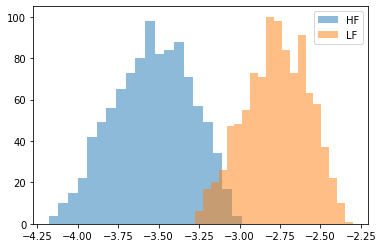

In [4]:
num_variable = 4
sample = lambda x: sample_p(x, num_variable)
def h_LF(x):
    ind = (x < -1).any(axis=1) + (x > 1).any(axis=1)
    ans = -2.48 - LF(x)
    ans[ind] = 100 * torch.norm(x[ind], dim=1)**2
    return ans
def h_HF(x):
    ind = (x < -1).any(axis=1) + (x > 1).any(axis=1)
    ans = -3.18 - HF(x)
    ans[ind] = 100 * torch.norm(x[ind], dim=1)**2
    return ans

X = sample(1000)
hf, lf = HF(X).detach().numpy(), LF(X).detach().numpy()
plt.hist(hf, bins=20, alpha=0.5, label='HF')
plt.hist(lf, bins=20, alpha=0.5, label='LF')
plt.legend(loc='upper right')

print('The 95\% quantile of HF and LF are')
print(np.sort(hf)[950], np.sort(lf)[950])
# h_LF = h_HF

The failure probability of the high-fidelity model is 0.055454
The optimal value of ell is 16.0


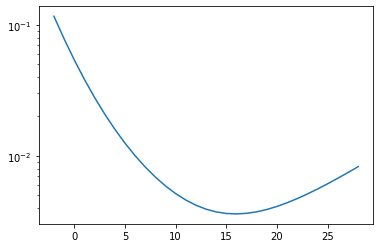

In [15]:
# selcting optimal ell
L = int(1e4)
M = int(1e6)
# fix samples
samps_M = sample(M)
samps_L = sample(L)
h_samps_M = h_LF(samps_M)
h_samps_L = h_LF(samps_L)
h_samps_LL = h_LF(samps_L)

ExH = np.mean((h_HF(samps_M) < 0).detach().numpy())
print("The failure probability of the high-fidelity model is", ExH)

def Zl(ell):
    return (-ell*torch.tanh(h_samps_M)).exp().sum() / M
def V(ell):
    varq1 = (torch.exp(ell*torch.tanh(h_samps_LL))[h_samps_L < 0]).sum() / L
    varq2 = ((h_samps_L < 0).sum())**2 / (L**2)
    return Zl(ell) * varq1 - varq2

ell_lst = np.linspace(-2, 28, 31)
V_lst = [V(torch.tensor(ell)).item() for ell in ell_lst]

plt.plot(ell_lst, V_lst)
plt.yscale('log')

if torch.sum(h_samps_L < 0) > 0:
    ell = ell_lst[torch.argmin(torch.tensor(V_lst))]
else:
    ell = 1.0
print('The optimal value of ell is', ell)

In [16]:
from tqdm import tqdm

Zc = Zl(ell)

def potential(z):
    return ell * torch.tanh(h_LF(z))

def unadjusted_langevin_algorithm(potential, n_samples=int(1e4), step=0.01):
    burn_in = 10000
    Z0 = sample(1)
    Zi = Z0
    samples = []
    for i in tqdm(range(n_samples + burn_in)):
        Zi.requires_grad_()
        u = potential(Zi).mean()
        grad = torch.autograd.grad(u, Zi)[0]
        Zi = Zi.detach() - step * grad + np.sqrt(2 * step) * torch.randn(1, num_variable)
        samples.append(Zi.detach())
    return torch.cat(samples, 0)[burn_in:]

def log_Q(potential, z_prime, z, step):
    z.requires_grad_()
    grad = torch.autograd.grad(potential(z).mean(), z)[0]
    return -(torch.norm(z_prime - z + step * grad, p=2, dim=1) ** 2) / (4 * step)

def metropolis_adjusted_langevin_algorithm(potential, burn_in=int(1e3), n_samples=int(1e4), step=0.01):
    Z0 = torch.zeros(1, num_variable)
    Zi = Z0
    samples = []
    pbar = tqdm(range(n_samples + burn_in))
    for i in pbar:
        Zi.requires_grad_()
        u = potential(Zi).mean()
        grad = torch.autograd.grad(u, Zi)[0]
        prop_Zi = Zi.detach() - step * grad + np.sqrt(2 * step) * torch.randn(1, num_variable)
        log_ratio = -potential(prop_Zi).mean() + potential(Zi).mean() +\
                    log_Q(potential, Zi, prop_Zi, step) - log_Q(potential, prop_Zi, Zi, step)
        if torch.rand(1) < torch.exp(log_ratio):
            Zi = prop_Zi
        samples.append(Zi.detach())
    return torch.cat(samples, 0)[burn_in:]

def weight(x:torch.Tensor): # evaluate the unnormalized weight for the given xi
    wt = Zc * (ell * torch.tanh(h_LF(x))).exp()
    return wt

q_lst = metropolis_adjusted_langevin_algorithm(potential, burn_in=int(1e4), n_samples=int(1e4), step=1e-3)
print('The number of failures sampled by q is ', (h_HF(q_lst) < 0).sum().item())
q_lst2 = q_lst[(q_lst < 1).all(axis=1) * (q_lst > -1).all(axis=1)]
print('The number of meaningful q samples is ', q_lst2.shape[0])

100%|██████████| 20000/20000 [35:45<00:00,  9.32it/s] 

The number of failures sampled by q is  5829
The number of meaningful q samples is  10000


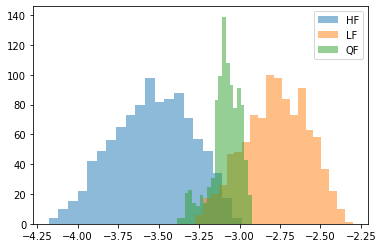

In [17]:
hf, lf, qf = HF(X).detach().numpy(), LF(X).detach().numpy(), HF(q_lst2[:1000]).detach().numpy()
plt.hist(hf, bins=20, alpha=0.5, label='HF')
plt.hist(lf, bins=20, alpha=0.5, label='LF')
plt.hist(qf, bins=20, alpha=0.5, label='QF')
plt.legend(loc='upper right')

In [18]:
q_lst = q_lst2
print((weight(q_lst)[h_HF(q_lst) < 0]).sum()/(len(q_lst)))
print((weight(q_lst)[h_HF(q_lst) < 0]**2).sum()/(len(q_lst)))
print(ExH)

tensor(0.0452)
tensor(0.0057)
0.055454


In [46]:
from sklearn.mixture import GaussianMixture
# Apply Gaussian mixture model for IS
GM_samps_all = samps_M[h_LF(samps_M) < 0]
print('There are ', GM_samps_all.shape[0], 'samples producing LF failure.')
# Choose 1000 of them
GM_trains = GM_samps_all[:1000]
print('The number of samples used in the Gaussian mixture model is', GM_trains.shape[0])
GM_model = GaussianMixture(n_components=10, random_state=0).fit(GM_trains.detach().numpy())
GM_samps = GM_model.sample(10000)[0]
GM_wegts = 0.5**num_variable * (np.exp(- GM_model.score_samples(GM_samps)))
print(GM_samps.shape, GM_wegts.shape)

There are  55990 samples producing LF failure.
The number of samples used in the Gaussian mixture model is 1000
(10000, 4) (10000,)


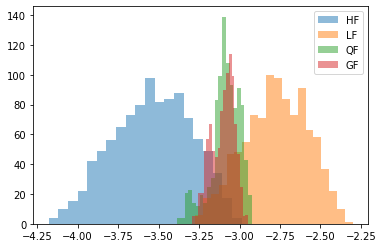

In [47]:
gf = HF(torch.from_numpy(GM_samps[:1000]).type(torch.FloatTensor)).detach().numpy()
plt.hist(hf, bins=20, alpha=0.5, label='HF')
plt.hist(lf, bins=20, alpha=0.5, label='LF')
plt.hist(qf, bins=20, alpha=0.5, label='QF')
plt.hist(gf, bins=20, alpha=0.5, label='GF')
plt.legend(loc='upper right')

In [48]:
MC_N_lst = (10**np.linspace(1, 4, 10)).astype('int')
MC = []
IS = []
GM = []
num_trial = 100
num_trial_gm = 10
for j in range(num_trial):
    MC_est_lst = []
    IS_est_lst = []
    GM_est_lst = []
    for MC_N in MC_N_lst:
        xi_p = sample(MC_N) # sample MC xi_p
        ind = np.random.choice(len(q_lst),MC_N)
        xi_q = q_lst[ind] # sample xi_q
        xi_g = torch.from_numpy(GM_samps[ind]).type(torch.FloatTensor) # sample xi_g
        wt_q = weight(xi_q) / MC_N
        wt_g = GM_wegts[ind] / MC_N
        MC_est_lst.append(np.mean((h_HF(xi_p) < 0).detach().numpy()))
        IS_est_lst.append(wt_q[h_HF(xi_q) < 0].sum().item())
        GM_est_lst.append(wt_g[h_HF(xi_g) < 0].sum().item())
    MC.append(MC_est_lst)
    IS.append(IS_est_lst)
    GM.append(GM_est_lst)

MC      = np.array(MC)
IS      = np.array(IS)
GM      = np.array(GM)
MC_mean = np.nanmean(MC, axis=0)
MC_std  = np.nanstd(MC, axis=0)
IS_mean = np.nanmean(IS, axis=0)
IS_std  = np.nanstd(IS, axis=0)
GM_mean = np.nanmean(GM, axis=0)
GM_std  = np.nanstd(GM, axis=0)
MC_err  = ((MC - ExH)**2)
IS_err  = ((IS - ExH)**2)
GM_err  = ((GM - ExH)**2)
MC_rmse = np.sqrt(np.nanmean(MC_err, axis=0))
IS_rmse = np.sqrt(np.nanmean(IS_err, axis=0))
GM_rmse = np.sqrt(np.nanmean(GM_err, axis=0))

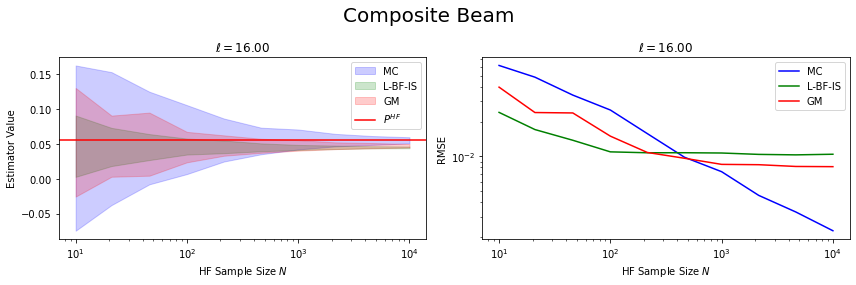

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Composite Beam', fontsize=20)
scale = 1.96

axs[0].fill_between(MC_N_lst, MC_mean-scale*MC_std, MC_mean+scale*MC_std,color='b',alpha=0.2,label='MC')
axs[0].fill_between(MC_N_lst, IS_mean-scale*IS_std, IS_mean+scale*IS_std,color='g',alpha=0.2,label='L-BF-IS')
axs[0].fill_between(MC_N_lst, GM_mean-scale*GM_std, GM_mean+scale*GM_std,color='r',alpha=0.2,label='GM')
axs[0].axhline(ExH,c='r',label=r'$P^{HF}$')
axs[0].set_xscale('log')
axs[0].set_xlabel(r'HF Sample Size $N$')
axs[0].set_ylabel('Estimator Value')
axs[0].legend()
axs[0].set_title(f'$\ell={ell:.2f}$')

axs[1].plot(MC_N_lst, MC_rmse,color='b',alpha=1.0,label='MC')
axs[1].plot(MC_N_lst, IS_rmse,color='g',alpha=1.0,label='L-BF-IS')
axs[1].plot(MC_N_lst, GM_rmse,color='r',alpha=1.0,label='GM')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel(r'HF Sample Size $N$')
axs[1].set_ylabel('RMSE')
axs[1].legend()
axs[1].set_title(f'$\ell={ell:.2f}$')

fig.tight_layout()
# fig.savefig('../../figures/beam.pdf', dpi=100)